In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

import pandas as pd

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from R125_bmimPF6_PR import configuration
data = pd.read_csv('R125IL.csv')

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [3]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(0.5)

# Constant kappa
m.fs.properties.PR_kappa_A['bmimPF6', 'R125'].fix(0.286364)
m.fs.properties.PR_kappa_A['R125', 'bmimPF6'].fix(-0.00356)
m.fs.properties.PR_kappa_B['bmimPF6', 'R125'].fix(0.0)
m.fs.properties.PR_kappa_B['R125', 'bmimPF6'].fix(0.0)

# Linear kappa
# m.fs.properties.PR_kappa_A['bmimPF6', 'R125'].fix(3.31046)
# m.fs.properties.PR_kappa_A['R125', 'bmimPF6'].fix(0.03431)
# m.fs.properties.PR_kappa_B['bmimPF6', 'R125'].fix(-2.2325)
# m.fs.properties.PR_kappa_B['R125', 'bmimPF6'].fix(-0.0200)

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].unfix()


In [4]:
bmim = np.linspace(data["x_bmimPF6"].iloc[7], data["x_bmimPF6"].iloc[0], 5)

P = np.zeros((len(bmim)))
P0 = np.zeros((len(bmim)))
R125_x1 = np.zeros((len(bmim)))
m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"] == m.fs.liq)

for i in range(len(bmim)-1):
    print(i)
    m.fs.liq = bmim[i]
    a = bmim[i]
#     print(a)
    b = 1-(bmim[i])
#     print(b)
    P0[i] = -2364949.08*b**2 + 2586229.24*b + 2343.45
#     print(P0)
    m.fs.F101.inlet.temperature.fix(283.001)
    m.fs.F101.inlet.pressure.fix(P0[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(1-(bmim[i]-0.05))
    m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].fix(bmim[i]-0.05)
    m.fs.F101.vap_outlet.temperature.fix(283.001)
    m.fs.F101.vap_outlet.pressure.fix(P0[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R125_x1[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R125_x1[i] = "NaN"
            P[i] = "NaN"

bmim2 = np.linspace(data["x_bmimPF6"].iloc[15], data["x_bmimPF6"].iloc[8], 5)

P2 = np.zeros((len(bmim2)))
P02 = np.zeros((len(bmim2)))
R125_x2 = np.zeros((len(bmim2)))

for i in range(len(bmim2)-1):
    print(i)
    m.fs.liq = bmim2[i]
    a = bmim2[i]
    b = 1-(bmim2[i])
    P02[i] = -2961931.59*b**2 + 3782140.40*b + 16243.20
    m.fs.F101.inlet.temperature.fix(298.001)
    m.fs.F101.inlet.pressure.fix(P02[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(1-(bmim2[i]-0.05))
    m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].fix(bmim2[i]-0.05)
    m.fs.F101.vap_outlet.temperature.fix(298.001)
    m.fs.F101.vap_outlet.pressure.fix(P02[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R125_x2[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
            P2[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R125_x2[i] = "NaN"
            P2[i] = "NaN"
            
bmim3 = np.linspace(data["x_bmimPF6"].iloc[23], data["x_bmimPF6"].iloc[16], 5)

P3 = np.zeros((len(bmim3)))
P03 = np.zeros((len(bmim3)))
R125_x3 = np.zeros((len(bmim3)))

for i in range(len(bmim3)-1):
    print(i)
    m.fs.liq = bmim3[i]
    a = bmim3[i]
    b = 1-(bmim3[i])
    P03[i] = 6404090.98*b + 28544.48
    m.fs.F101.inlet.temperature.fix(323.001)
    m.fs.F101.inlet.pressure.fix(P03[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(1-(bmim3[i]-0.05))
    m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].fix(bmim3[i]-0.05)
    m.fs.F101.vap_outlet.temperature.fix(323.001)
    m.fs.F101.vap_outlet.pressure.fix(P03[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R125_x3[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
            P3[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R125_x3[i] = "NaN"
            P3[i] = "NaN"
            
bmim4 = np.linspace(data["x_bmimPF6"].iloc[31], data["x_bmimPF6"].iloc[24], 5)

P4 = np.zeros((len(bmim4)))
P04 = np.zeros((len(bmim4)))
R125_x4 = np.zeros((len(bmim4)))

for i in range(len(bmim4)-1):
    print(i)
    m.fs.liq = bmim4[i]
    a = bmim4[i]
    b = 1-(bmim4[i])
    P04[i] = 11070568.93*b + 23657.43
    m.fs.F101.inlet.temperature.fix(348.001)
    m.fs.F101.inlet.pressure.fix(P04[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(1-(bmim4[i]-0.05))
    m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].fix(bmim4[i]-0.05)
    m.fs.F101.vap_outlet.temperature.fix(348.001)
    m.fs.F101.vap_outlet.pressure.fix(P04[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R125_x4[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
            P4[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R125_x4[i] = "NaN"
            P4[i] = "NaN"

0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3


In [5]:
print(P)
# print(data["pressure"])
# print(R125_x)
# print(data["x_R125"])
print(R125_x1)
print(P2)
# print(data["pressure"])
# print(R125_x)
# print(data["x_R125"])
print(R125_x2)

[723229.89049692 655582.11716147 511321.4079089  298804.47040297
      0.        ]
[0.462   0.34975 0.2375  0.12525 0.     ]
[1054395.99782039  889132.55200516  663539.15997684  391560.54536326
       0.        ]
[0.363 0.278 0.193 0.108 0.   ]


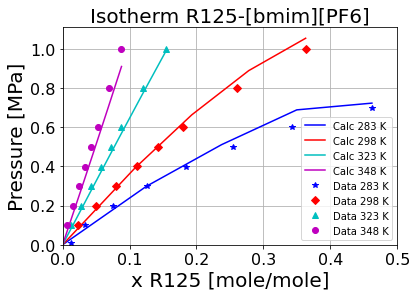

In [6]:
#     P[i] = P[i]*1e6
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

P22= np.zeros((len(P2)))

for i in range(len(P22)):
    P22[i] = P2[i]/1e6    
    
P32= np.zeros((len(P3)))

for i in range(len(P32)):
    P32[i] = P3[i]/1e6

P42= np.zeros((len(P4)))

for i in range(len(P42)):
    P42[i] = P4[i]/1e6

P1[1]=0.6888

plt.plot(R125_x1,P1,"b",label="Calc 283 K")  
plt.plot(R125_x2,P22,"r",label="Calc 298 K") 
plt.plot(R125_x3,P32,"c",label="Calc 323 K")
plt.plot(R125_x4,P42,"m",label="Calc 348 K")
plt.plot(data["x_R125"][0:8],data["pressure"][0:8]/1e6,"*",color='b',label="Data 283 K")  
plt.plot(data["x_R125"][8:16],data["pressure"][8:16]/1e6,"D",color='r',label="Data 298 K") 
plt.plot(data["x_R125"][16:24],data["pressure"][16:24]/1e6,"^",color='c',label="Data 323 K") 
plt.plot(data["x_R125"][24:],data["pressure"][24:]/1e6,"o",color='m',label="Data 348 K") 
plt.title('Isotherm R125-[bmim][PF6]',fontsize=20)
plt.ylabel('Pressure [MPa]',fontsize=20)
plt.xlabel('x R125 [mole/mole]',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.ylim(0,1.110000)
plt.xlim(0,0.5)
plt.legend(fontsize=10)
plt.savefig('Isotherm R125-[bmim][PF6]_bin.png', bbox_inches='tight',dpi=300)
plt.show()


In [7]:
df = pd.DataFrame(P)
# df.to_csv('P_cons_125.csv')
# df.to_csv('P_lin_125.csv')
# df.to_csv('P_ter_125.csv')